In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.coordinates import frames
import datetime as dt
from sunpy.coordinates import propagate_with_solar_surface
import glob
from asheis import asheis
import eispac

In [3]:
# Function to define the regions of interest and get the parameter values for those ROIs
def get_iris_rois(map):
    crd_time = dt.datetime.strptime('2023-03-29T11:14:04', '%Y-%m-%dT%H:%M:%S')

    # Regions of interest to compare different regions of EUI image
    crd_r1_bl = SkyCoord(214*u.arcsec, -210*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r1_tr = SkyCoord(218*u.arcsec, -206*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r2_bl = SkyCoord(207*u.arcsec, -208*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r2_tr = SkyCoord(212*u.arcsec, -204*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r3_bl = SkyCoord(213*u.arcsec, -203*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r3_tr = SkyCoord(218*u.arcsec, -197*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r4_bl = SkyCoord(218*u.arcsec, -215*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r4_tr = SkyCoord(234*u.arcsec, -207*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r5_bl = SkyCoord(194*u.arcsec, -201*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r5_tr = SkyCoord(202*u.arcsec, -198*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r6_bl = SkyCoord(213*u.arcsec, -187*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)
    crd_r6_tr = SkyCoord(228*u.arcsec, -169*u.arcsec, frame=frames.Helioprojective, observer='earth', obstime=crd_time)

    with propagate_with_solar_surface():
        r1_bl_crd = (crd_r1_bl).transform_to(map.coordinate_frame)
        r1_tr_crd = (crd_r1_tr).transform_to(map.coordinate_frame)
        r2_bl_crd = (crd_r2_bl).transform_to(map.coordinate_frame)
        r2_tr_crd = (crd_r2_tr).transform_to(map.coordinate_frame)
        r3_bl_crd = (crd_r3_bl).transform_to(map.coordinate_frame)
        r3_tr_crd = (crd_r3_tr).transform_to(map.coordinate_frame)
        r4_bl_crd = (crd_r4_bl).transform_to(map.coordinate_frame)
        r4_tr_crd = (crd_r4_tr).transform_to(map.coordinate_frame)
        r5_bl_crd = (crd_r5_bl).transform_to(map.coordinate_frame)
        r5_tr_crd = (crd_r5_tr).transform_to(map.coordinate_frame)
        r6_bl_crd = (crd_r6_bl).transform_to(map.coordinate_frame)
        r6_tr_crd = (crd_r6_tr).transform_to(map.coordinate_frame)

    return r1_bl_crd,r1_tr_crd,r2_bl_crd,r2_tr_crd,r3_bl_crd,r3_tr_crd,r4_bl_crd,r4_tr_crd,r5_bl_crd,r5_tr_crd,r6_bl_crd,r6_tr_crd


In [4]:
eis_evts = sorted(glob.glob('/Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/*.data.h5'))

In [ ]:
# for file in eis_evts:


In [14]:
from eis_average_pixel import eis_averaged_fip
import os
eis_evts = sorted(glob.glob('/Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/*.data.h5'))

# Ensure the results directory exists
results_dir = 'eis_composition_results'
os.makedirs(results_dir, exist_ok=True)

for eis_evt in eis_evts:
    # Extract the filename from the full path
    eis_evt_name = os.path.basename(eis_evt)
    
    # Create a new file for each EIS event
    result_file = os.path.join(results_dir, f'{eis_evt_name}_results.txt')
    
    with open(result_file, 'w') as f:
        f.write(f"Results for EIS Event: {eis_evt_name}\n\n")
        
        # List of all region coordinates
        data_cube = eispac.read_cube(eis_evt, 195.119)
        tmplt_loc = eispac.data.get_fit_template_filepath("fe_12_195_119.1c.template.h5")
        tmplt = eispac.read_template(tmplt_loc)
        fit_res = eispac.fit_spectra(data_cube, tmplt, ncpu='max')
        fexii_map = fit_res.get_map(component=0, measurement='intensity')
        _eis_map, Txshift, Tyshift = alignment(eis_evt, return_shift=True)

        r1_bl_crd,r1_tr_crd,r2_bl_crd,r2_tr_crd,r3_bl_crd,r3_tr_crd,r4_bl_crd,r4_tr_crd,r5_bl_crd,r5_tr_crd,r6_bl_crd,r6_tr_crd=get_iris_rois(fexii_map)
        regions = [
            (r1_bl_crd, r1_tr_crd),
            (r2_bl_crd, r2_tr_crd),
            (r3_bl_crd, r3_tr_crd),
            (r4_bl_crd, r4_tr_crd),
            (r5_bl_crd, r5_tr_crd),
            (r6_bl_crd, r6_tr_crd)
        ]
        # Convert each coordinate pair to the format expected by eis_average
        eis_average_coords = []
        for bl_crd, tr_crd in regions:
            eis_average_coords.append([
                [bl_crd.Tx.value-Txshift, bl_crd.Ty.value-Tyshift],
                [tr_crd.Tx.value-Txshift, tr_crd.Ty.value-Tyshift]
            ])

        for i, coords in enumerate(eis_average_coords, 1):
            bl_crd, tr_crd = coords
            fip_ratio, mcmc_lines, chi2 = eis_averaged_fip(eis_evt, bl_crd, tr_crd)
            f.write(f"Region {i}: FIP ratio = {fip_ratio}, Chi-squared = {chi2}\n")
        
        f.write("\n")  # Add a blank line between events

    print(f"Results for {eis_evt_name} have been written to {result_file}")

print("All results have been saved in individual files in the 'eis_composition_results' directory.")


Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 195.12 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 60 exposures, each with 160 spectra
 + running mpfit on 12 cores (of 12)


/Users/andysh.to/miniconda3/envs/solar/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:13.663616
   9440 spectra fit without issues
   160 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Checking fe_8_185.21
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/da

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.665237
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.56---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 186.57 [Angstroms] in window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.574264
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.38---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 188.67 [Angstroms] in window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.639743
   1 spectra fit without issues
   0 spectra have < 10 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.08---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 197.81 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offse

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.631919
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.11---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 184.60 [Angstroms] in window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.735573
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.61---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 188.20 [Angstroms] in window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.691297
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.13---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 188.20 [Angstroms] in window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.573958
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.12---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 186.83 [Angstroms] in window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.572373
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.34---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 195.11 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.752452
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.21---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 192.41 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.665114
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 1.22---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 202.07 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.602062
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 0.67---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 203.78 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.544156
   1 spectra fit without issues
   0 spectra have < 10 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 0.47---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 264.77 [Angstroms] in window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offse

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.522732
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 4.03---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 270.48 [Angstroms] in window 3
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.505881
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 5.11---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 284.09 [Angstroms] in window 3
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.532716
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 4.72---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 262.94 [Angstroms] in window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.577604
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 3.53---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 254.97 [Angstroms] in window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.498361
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 2.85---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 253.17 [Angstroms] in window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.528567
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 2.75---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 263.71 [Angstroms] in window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.503897
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 3.75---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 254.97 [Angstroms] in window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.509165
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 2.86---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 203.78 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.507375
   1 spectra fit without issues
   0 spectra have < 10 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 0.47---------------------
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 202.07 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offse

 + working on exposure 001

Finished computing fits!
   runtime : 0:00:01.519171
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
---------------------Calibrated using Warren et al. 2014; Ratio: 0.67---------------------


ValueError: could not broadcast input array from shape (50,) into shape (101,)

Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 195.12 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 60 exposures, each with 160 spectra
 + running mpfit on 12 cores (of 12)
 + working on exposure 060

Finished computing fits!
   runtime : 0:00:15.227828
   9440 spectra fit without issues
   160 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/andysh.to/miniconda3/envs/solar/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent


In [191]:
r1_bl_crd,r1_tr_crd,r2_bl_crd,r2_tr_crd,r3_bl_crd,r3_tr_crd,r4_bl_crd,r4_tr_crd,r5_bl_crd,r5_tr_crd,r6_bl_crd,r6_tr_crd = get_iris_rois(fexii_map)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/var/folders/6w/c91jbrwd1k501xpqgh_czqbmvjj465/T/ipykernel_58576/3014456719.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


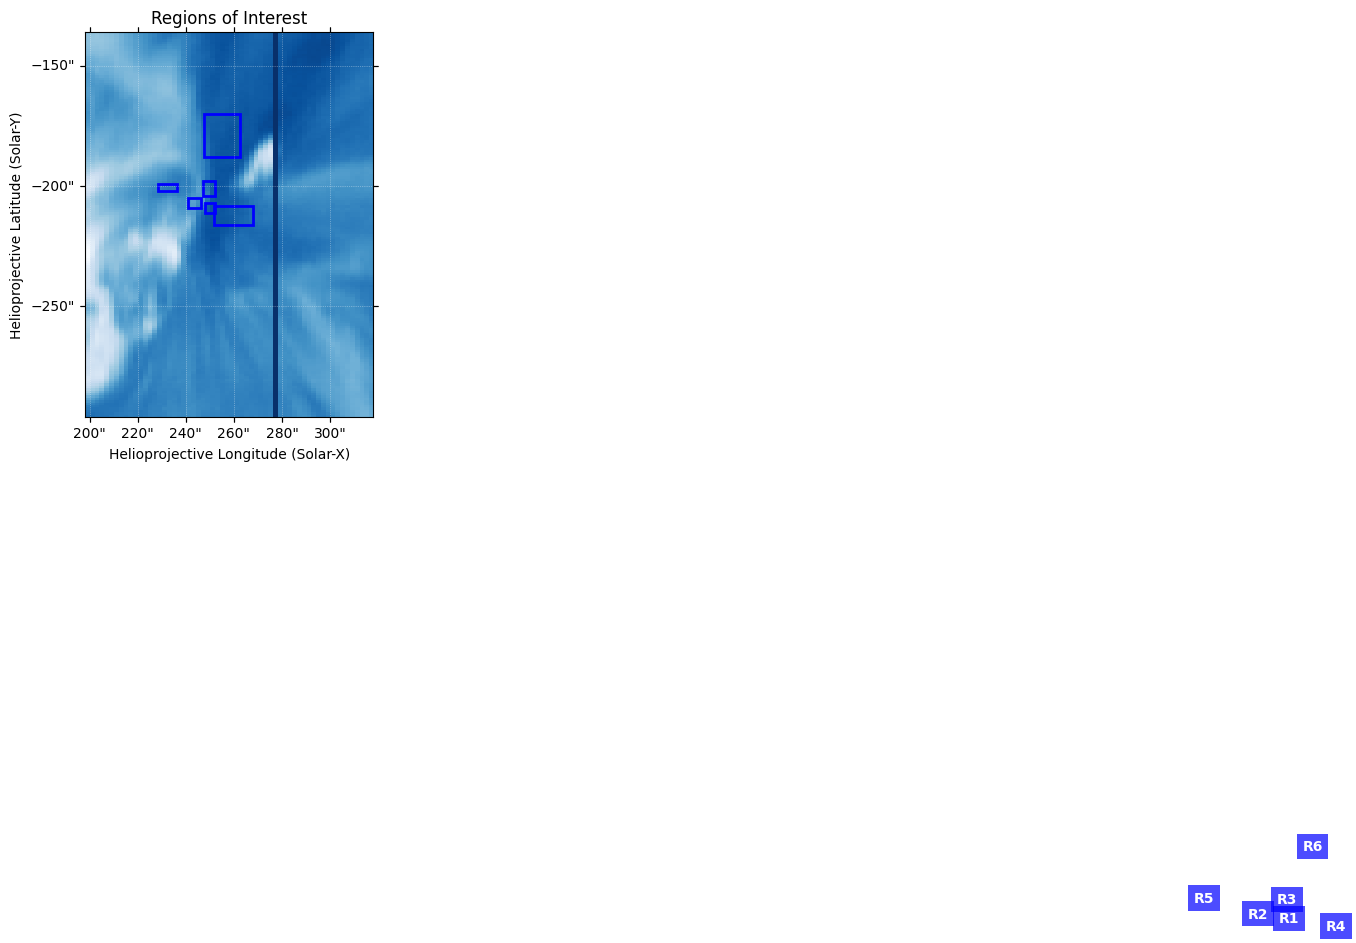

In [13]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection=fexii_map)
fexii_map.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)

# List of all coordinate pairs
coord_pairs = [
    (r1_bl_crd, r1_tr_crd),
    (r2_bl_crd, r2_tr_crd),
    (r3_bl_crd, r3_tr_crd),
    (r4_bl_crd, r4_tr_crd),
    (r5_bl_crd, r5_tr_crd),
    (r6_bl_crd, r6_tr_crd)
]

# Loop through all coordinate pairs and plot them
for i, (bl_crd, tr_crd) in enumerate(coord_pairs, 1):
    coords = SkyCoord(
        Tx=[bl_crd.Tx.value, tr_crd.Tx.value],
        Ty=[bl_crd.Ty.value, tr_crd.Ty.value],
        frame=fexii_map.coordinate_frame,
        unit=u.arcsec
    )
    fexii_map.draw_quadrangle(
        coords,
        axes=ax,
        edgecolor="blue",
        linestyle="-",
        linewidth=2,
    )
    
    # Add text label for each region
    center_x = (bl_crd.Tx.value + tr_crd.Tx.value) / 2
    center_y = (bl_crd.Ty.value + tr_crd.Ty.value) / 2
    ax.text(center_x, center_y, f"R{i}", color="white", fontweight="bold", 
            ha="center", va="center", bbox=dict(facecolor="blue", alpha=0.7, edgecolor="none"))

plt.title("Regions of Interest")
plt.tight_layout()

In [193]:
from eis_average.function import average_spectral_data
import eispac

In [194]:
print([r1_bl_crd.Tx.value, r1_bl_crd.Ty.value])
print([r1_tr_crd.Tx.value, r1_tr_crd.Ty.value])

data_averaged, data_cropped = average_spectral_data(data_cube, tmplt, [r1_bl_crd.Tx.value, r1_bl_crd.Ty.value], [r1_tr_crd.Tx.value, r1_tr_crd.Ty.value])

[216.88862131045445, -210.08356892192884]
[220.8914582334983, -206.08513765573548]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset - OFFSET: -0.0
5 3
NDCube
------
Dimensions: [ 5.  3. 13.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('em.wl',)]
Unit: erg / (s sr cm2)
Data Type: float32
INFO: overwriting NDData's current meta with specified meta. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [195]:
data_cropped.data
# Average the data to create a 1D array
averaged_data = np.mean(data_cropped.data, axis=(0, 1))

averaged_data

array([   57.085617,    76.412766,    85.38966 ,   188.05779 ,
         471.94104 ,  1139.4045  ,  1953.2753  ,  1801.6146  ,
        1107.5278  ,   525.6314  , -1063.3359  ,   137.64687 ,
          93.05296 ], dtype=float32)

In [196]:
data_cutout

NDCube
------
Dimensions: [ 1.  1. 13.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('em.wl',)]
Unit: erg / (s sr cm2)
Data Type: float32

In [222]:
tmplt_loc

'/Users/andysh.to/miniconda3/envs/solar/lib/python3.11/site-packages/eispac/data/templates/fe_12_195_119.2c.template.h5'

In [227]:
r1_bl_crd

<SkyCoord (Helioprojective: obstime=2023-03-29T11:34:37.500, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-03-29T11:34:37.500, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (216.88862131, -210.08356892, 0.99385635)>

In [230]:
data_cube

NDCube
------
Dimensions: [ 160.   60. 1024.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('em.wl',)]
Unit: erg / (s sr cm2)
Data Type: float32

In [229]:
data_averaged

NDCube
------
Dimensions: [ 1.  1. 13.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('em.wl',)]
Unit: erg / (s sr cm2)
Data Type: float32

In [232]:
tmplt = eispac.read_template(tmplt_loc)
data_cube = eispac.read_cube(eis_evts[0], tmplt.central_wave)
data_averaged, data_cropped = average_spectral_data(
    data_cube, tmplt, 
    [r1_bl_crd.Tx.value, r1_bl_crd.Ty.value], 
    [r1_tr_crd.Tx.value, r1_tr_crd.Ty.value]
)

fit_res = eispac.fit_spectra(data_averaged, tmplt, ncpu='max')


Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 195.11 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (1.12158621e-14, -6.7001369, 1.49339412e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset - OFFSET: -0.0
5 3
NDCube
------
Dimensions: [ 5.  3. 13.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('em.wl',)]
Unit: erg / (s sr cm2)
Data Type: float32
INFO: overwriting NDData's current meta with specified meta. [astropy.nddata.nddata]
I

Error: missing or invalid data. Please input a filepath, EISCube, or complete set of intensity, wavelength, and error arrays.


In [225]:
fit_res

In [221]:
fit_res

In [216]:
averaged_fit_res = eispac.fit_spectra(data_averaged, tmplt, ncpu='max')


Error: missing or invalid data. Please input a filepath, EISCube, or complete set of intensity, wavelength, and error arrays.


In [215]:
averaged_fit_res = eispac.fit_spectra(data_averaged, tmplt, ncpu='max')
averaged_intensity = averaged_fit_res.get_map(component=0, measurement='intensity')
print(f'Averaged Intensity: {averaged_intensity.data[0][0]}')

Error: missing or invalid data. Please input a filepath, EISCube, or complete set of intensity, wavelength, and error arrays.


AttributeError: 'NoneType' object has no attribute 'get_map'

In [168]:
# Test with filename and EISCube
eis_cube = asheis(filename, eiscube=data_cutout_sum)




In [199]:
ash=ashmcmc(filename, eiscube=data_cutout_sum)

In [202]:
Lines, dim, dem_num = ash.check_existing_lines()
dict = eis_cube.dict

Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Checking fe_8_185.21
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 185.21 [Angstroms] in window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Checking fe_8_186.60
Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 186.57 [Angstroms] in window 0
INFO: uncertainty s

In [208]:
Lines

['fe_8_185.21',
 'fe_8_186.60',
 'fe_9_188.50',
 'fe_9_197.86',
 'fe_10_184.54',
 'fe_11_188.22',
 'fe_11_188.30',
 'fe_12_186.88',
 'fe_12_195.12',
 'fe_12_192.39',
 'fe_13_202.04',
 'fe_13_203.83',
 'fe_14_264.79',
 'fe_14_270.52',
 'fe_15_284.16',
 'fe_16_262.98',
 'fe_17_254.87',
 'fe_22_253.10',
 'fe_23_263.76',
 'fe_24_255.10']

In [210]:
# for file in eis_evts:
data_cube = eispac.read_cube(eis_evts[0], 195.119)
tmplt_loc = eispac.data.get_fit_template_filepath("fe_12_195_119.2c.template.h5")
tmplt = eispac.read_template(tmplt_loc)
fit_res = eispac.fit_spectra(data_cube, tmplt, ncpu='max')
fexii_map = fit_res.get_map(component=0, measurement='intensity')

Data file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/data_eis/eis_20230329_111848.head.h5
Found a wavelength 195.12 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 60 exposures, each with 160 spectra
 + running mpfit on 12 cores (of 12)
 + working on exposure 060

Finished computing fits!
   runtime : 0:00:06.404202
   9440 spectra fit without issues
   160 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/andysh.to/miniconda3/envs/solar/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent


In [211]:
averaged_fit_res = eispac.fit_spectra(data_cutout_averaged, tmplt, ncpu='max')
averaged_intensity = averaged_fit_res.get_map(component=0, measurement='intensity')
print(f'Averaged Intensity: {averaged_intensity.data[0][0]}')

NameError: name 'data_cutout_averaged' is not defined

In [184]:
averaged_intensity

NameError: name 'averaged_intensity' is not defined

In [89]:
from ashmcmc import ashmcmc
test = ashmcmc(data_cutout_sum)

In [90]:
test.fit_data()

Checking fe_8_185.21
Checking fe_8_186.60
Checking fe_9_188.50
Checking fe_9_197.86
Checking fe_10_184.54
Checking fe_11_188.22
Checking fe_11_188.30
Checking fe_12_186.88
Checking fe_12_195.12
Checking fe_12_192.39
Checking fe_13_202.04
Checking fe_13_203.83
Checking fe_14_264.79
Checking fe_14_270.52
Checking fe_15_284.16
Checking fe_16_262.98
Checking fe_17_254.87
Checking fe_22_253.10
Checking fe_23_263.76
Checking fe_24_255.10


Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Data file does not exist, /Users/andysh.to/Script/Python_Script/demcmc_FIP_averaged/unknown
Error: Dat

------------------------------Found 1 usable lines------------------------------
Found 1 usable lines for DEM


0it [00:00, ?it/s]


([], array([[[0.]]]), array([[[0.]]]))

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection=fexii_map)
fexii_map.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)
for 


In [ ]:
len(eis_evts)

In [ ]:
from sunpy.net import Fido, attrs as a
import eispac.net
from eispac.net.attrs import FileType
results = Fido.search(a.Time('2023-03-29 11:00:00','2023-03-29 16:00:00'),
                      a.Instrument('EIS'),
                      a.Physobs.intensity,
                      a.Source('Hinode'),
                      a.Provider('NRL'),
                      a.Level('1'))  



# eispac.download_hdf5_data('eis_20160720_005944.data.h5')

In [ ]:
# Fetch the EIS data files
downloaded_files = Fido.fetch(results)

# Print the downloaded files
print("Downloaded files:")
for file in downloaded_files:
    print(file)
